<a href="https://colab.research.google.com/github/yunju-1118/EWHA/blob/main/OB2_Project1_SCV_CatBoost_%EC%8B%A0%EC%9A%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

random_seed = 42, test_size = 0.2, dataset: hotel

전처리: 현경 (~ 9/18)

LGBM: 윤주

CatBoost & SVM: 신우

Logistic: 재선

https://www.kaggle.com/datasets/ahsan81/hotel-reservations-classification-dataset

### **Data Dictionary**

- Booking_ID: unique identifier of each booking

- no_of_adults: Number of adults
- no_of_children: Number of Children
- no_of_weekend_nights: Number of weekend nights (Saturday or Sunday) the guest stayed or booked to stay at the hotel
- no_of_week_nights: Number of week nights (Monday to Friday) the guest stayed or booked to stay at the hotel
- type_of_meal_plan: Type of meal plan booked by the customer:
- required_car_parking_space: Does the customer require a car parking space? (0 - No, 1- Yes)
- room_type_reserved: Type of room reserved by the customer. The values are ciphered (encoded) by INN Hotels.
- lead_time: Number of days between the date of booking and the arrival date
- arrival_year: Year of arrival date
- arrival_month: Month of arrival date
- arrival_date: Date of the month
- market_segment_type: Market segment designation.
- repeated_guest: Is the customer a repeated guest? (0 - No, 1- Yes)
- no_of_previous_cancellations: Number of previous bookings that were canceled by the customer prior to the current booking
- no_of_previous_bookings_not_canceled: Number of previous bookings not canceled by the customer prior to the current booking
- avg_price_per_room: Average price per day of the reservation; prices of the rooms are dynamic. (in euros)
- no_of_special_requests: Total number of special requests made by the customer (e.g. high floor, view from the room, etc)
- **booking_status** (target): Flag indicating if the booking was canceled or not.

## **Import libraries and dataset**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
hotel = pd.read_csv('/content/drive/MyDrive/Hotel Reservations.csv')

## 전처리

각 모델별로 다르게 접근

1. Logistic Regression

2. LGBM

3. SVC

4. CatBoost

### 전체 모델 공통 처리 사항
1. datetime  변환
2. 범주형 변수 Label Encoding
3. binary 변수
4. 파생 변수
5. 필요 없는 변수 drop


++ KNN을 이용해서 거리가 비슷한 데이터 활용하는 방식은 tree 기반보다는 Logistic Regressiong, SVC 같이 조금 더 단순한 모델에 좋다고 해서 일단 두 모델에만 추가해놨어요!

그리고 KNN 이용한거는 무조건 train/test를 나누고 적용을 해야 한다고 해서 일단
train/test split도 제가 코드 작성해 둿어요!

날짜 이상한거 체크하기

In [ ]:
import pandas as pd
import numpy as np

for c in ["arrival_year","arrival_month","arrival_date"]:
    hotel[c] = pd.to_numeric(hotel[c], errors="coerce")

ym = pd.to_datetime(
    hotel["arrival_year"].astype("Int64").astype(str) + "-" +
    hotel["arrival_month"].astype("Int64").astype(str).str.zfill(2) + "-01",
    errors="coerce"
)
last_day = (ym + pd.offsets.MonthEnd(0)).dt.day

invalid_month = ~hotel["arrival_month"].between(1, 12)
invalid_day_low = hotel["arrival_date"] < 1
invalid_day_high = hotel["arrival_date"] > last_day
invalid_yearmonth = ym.isna()
bad_mask = invalid_month | invalid_day_low | invalid_day_high | invalid_yearmonth

ok = ~bad_mask
hotel.loc[ok, "arrival_date_full"] = pd.to_datetime({
    "year":  hotel.loc[ok, "arrival_year"],
    "month": hotel.loc[ok, "arrival_month"],
    "day":   hotel.loc[ok, "arrival_date"],
}, errors="coerce")

hotel.loc[bad_mask, "arrival_date_full"] = pd.NaT

problem_preview = hotel.loc[bad_mask, ["arrival_year","arrival_month","arrival_date"]].head(10)
print(problem_preview)
print("문제 행 수:", bad_mask.sum(), " / 전체:", len(hotel))

      arrival_year  arrival_month  arrival_date
2626          2018              2            29
3677          2018              2            29
5600          2018              2            29
6343          2018              2            29
7648          2018              2            29
8000          2018              2            29
8989          2018              2            29
9153          2018              2            29
9245          2018              2            29
9664          2018              2            29
문제 행 수: 37  / 전체: 36275


In [ ]:
import pandas as pd

for c in ["arrival_year", "arrival_month", "arrival_date"]:
    hotel[c] = pd.to_numeric(hotel[c], errors="coerce")

hotel["arrival_date_full"] = pd.to_datetime({
    "year": hotel["arrival_year"],
    "month": hotel["arrival_month"],
    "day": hotel["arrival_date"]
}, errors="coerce")

hotel = hotel.dropna(subset=["arrival_date_full"]).reset_index(drop=True)

print("남은 행 개수:", len(hotel))

남은 행 개수: 36238


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

## datetime 하나로 합치는 코드
tmp = hotel.rename(columns={
    "arrival_year": "year",
    "arrival_month": "month",
    "arrival_date": "day"
})

hotel["arrival_date_full"] = pd.to_datetime(tmp[["year","month","day"]])


In [ ]:
## 범주형 변수 처리하는 코드 (binary였던 거는 그대로 냅뒀어용)
cat_cols = ["type_of_meal_plan", "room_type_reserved", "market_segment_type"]
le_dict = {}
for col in cat_cols:
    le = LabelEncoder()
    hotel[col] = le.fit_transform(hotel[col])
    le_dict[col] = le


## 변수 drop
hotel = hotel.drop(columns=["Booking_ID","arrival_year", "arrival_date"])

In [ ]:
## 파생 변수
## 총 숙박일수
hotel["total_nights"] = hotel["no_of_weekend_nights"] + hotel["no_of_week_nights"]

## 리드타임 그룹화 -- 구간은 일주일, 한달, 세달, 반년, 일년, 일년 이상으로 나눴습니다!
hotel["lead_time_group"] = pd.cut(hotel["lead_time"],
                                  bins=[-1,7,30,90,180,365,800],
                                  labels=["<1w","1w-1m","1-3m","3-6m","6-12m",">1y"])

## 평균 1박당 가격 (NaN은 0으로)
hotel["avg_price_per_night"] = hotel["avg_price_per_room"] / hotel["total_nights"].replace(0, np.nan)
hotel["avg_price_per_night"] = hotel["avg_price_per_night"].fillna(0)

## 동반 인원
hotel["total_guests"] = hotel["no_of_adults"] + hotel["no_of_children"]

## 자녀
hotel["has_children"] = (hotel["no_of_children"] > 0).astype(int)

## 취소 비율
hotel["cancel_ratio"] = hotel["no_of_previous_cancellations"] / (
    hotel["no_of_previous_cancellations"] + hotel["no_of_previous_bookings_not_canceled"] + 1
)

## 이전 예약 경험
hotel["has_prev_booking"] = (
    (hotel["no_of_previous_cancellations"] + hotel["no_of_previous_bookings_not_canceled"]) > 0
).astype(int)

## 성수기
hotel["is_peak"] = hotel["arrival_month"].isin([6,7,8,12]).astype(int)

## 식사 플랜
hotel["no_meal_plan"] = (hotel["type_of_meal_plan"] == le_dict["type_of_meal_plan"].transform(["Not Selected"])[0]).astype(int)

## 2차 전처리 -- 추가 파생 변수

(sin, cos 처리 관련) & 요일 관련 변수 추가

In [ ]:
if "arrival_date_full" in hotel.columns:
    hotel["arrival_date_full"] = pd.to_datetime(hotel["arrival_date_full"], errors="coerce")

    hotel["arrival_day_of_week"] = hotel["arrival_date_full"].dt.dayofweek

In [ ]:
hotel["month_sin"] = np.sin(2 * np.pi * hotel["arrival_month"] / 12)
hotel["month_cos"] = np.cos(2 * np.pi * hotel["arrival_month"] / 12)

hotel["dow_sin"] = np.sin(2 * np.pi * hotel["arrival_day_of_week"] / 7)
hotel["dow_cos"] = np.cos(2 * np.pi * hotel["arrival_day_of_week"] / 7)

가격 관련 추가 변수
- 1인당 가격, 성수기일 경우의 방 가격

In [ ]:
hotel["price_per_guest"] = hotel["avg_price_per_room"] / (hotel["total_guests"].replace(0, np.nan))
hotel["price_per_guest"] = hotel["price_per_guest"].fillna(0)

hotel["peak_price"] = hotel["avg_price_per_room"] * hotel["is_peak"]

lead_time 비선형성 + month랑 곱해서 시즌 별 lead_Time 패턴 고려

In [ ]:
hotel["log_lead_time"] = np.log1p(hotel["lead_time"])

hotel["lead_x_month"] = hotel["lead_time"] * hotel["arrival_month"]

취소 경험 여부

In [ ]:
hotel["ever_canceled"] = (hotel["no_of_previous_cancellations"] > 0).astype(int)

## 1차 전처리 코드 -- KNN 적용 관련

In [ ]:
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor

def transform_with_knn_env(
    X_train: pd.DataFrame, y_train: pd.Series,
    X_test: pd.DataFrame,
    env_features = ["type_of_meal_plan", "required_car_parking_space",
                    "room_type_reserved", "no_of_special_requests"],
    k: int = 10
):
    ## 이웃 취소율
    knn_cls = KNeighborsClassifier(n_neighbors=k)
    knn_cls.fit(X_train[env_features], y_train)
    tr_env_cancel = knn_cls.predict_proba(X_train[env_features])[:, 1]
    te_env_cancel = knn_cls.predict_proba(X_test[env_features])[:, 1]

    ## 이웃 평균 1박 가격
    knn_reg = KNeighborsRegressor(n_neighbors=k)
    knn_reg.fit(X_train[env_features], X_train["avg_price_per_night"])
    tr_env_price = knn_reg.predict(X_train[env_features])
    te_env_price = knn_reg.predict(X_test[env_features])

    X_train_knn = X_train.copy()
    X_test_knn  = X_test.copy()

    X_train_knn["env_cancel_rate"] = tr_env_cancel
    X_test_knn["env_cancel_rate"]  = te_env_cancel
    X_train_knn["env_avg_price"]   = tr_env_price
    X_test_knn["env_avg_price"]    = te_env_price

    return X_train_knn, X_test_knn

### SVC

1. 스케일링, 로그 변환
2. 이상치 제거!


In [ ]:
df_svc = hotel.copy()

 ## 이상치 제거
df_svc = df_svc[df_svc["avg_price_per_room"] < 500]

## 로그 변환
for col in ["lead_time", "no_of_previous_cancellations", "no_of_previous_bookings_not_canceled", "no_of_children"]:
    df_svc[col] = np.log1p(df_svc[col])

X_svc = df_svc.drop(columns=["booking_status","arrival_date_full"])
y_svc = (df_svc["booking_status"] == "Canceled").astype(int)

X_tr_svc, X_te_svc, y_tr_svc, y_te_svc = train_test_split(X_svc, y_svc, test_size=0.2, random_state=42)

X_tr_svc, X_te_svc = transform_with_knn_env(
    X_tr_svc, y_tr_svc, X_te_svc,
    env_features=["type_of_meal_plan","required_car_parking_space","room_type_reserved","no_of_special_requests"],
    k=10
)

## 스케일링
scaler = StandardScaler()

num_cols_svc = [
    "no_of_adults","no_of_children","no_of_weekend_nights","no_of_week_nights",
    "lead_time","avg_price_per_room","total_nights","avg_price_per_night",
    "total_guests","cancel_ratio","no_of_special_requests"
]

for c in ["env_cancel_rate", "env_avg_price"]:
    if c in X_tr_svc.columns:
        num_cols_svc.append(c)

num_cols_svc = [c for c in num_cols_svc if c in X_tr_svc.columns]

X_tr_svc.loc[:, num_cols_svc] = scaler.fit_transform(X_tr_svc[num_cols_svc])
X_te_svc.loc[:, num_cols_svc] = scaler.transform(X_te_svc[num_cols_svc])

X_svc_train, X_svc_test, y_svc_train, y_svc_test = X_tr_svc, X_te_svc, y_tr_svc, y_te_svc

NameError: name 'train_test_split' is not defined

In [ ]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVC
from sklearn.metrics import (
    roc_auc_score, average_precision_score, log_loss,
    accuracy_score, precision_recall_fscore_support, confusion_matrix
)

SVC가 수치형만 받는데, lead_time_group 같은 문자열(예: '3-6m')이 그대로 남아 있어서
→ 문자열/카테고리 컬럼을 원-핫 인코딩(또는 드롭)한 뒤 학습

In [ ]:
df_svc = hotel.copy()
df_svc = df_svc[df_svc["avg_price_per_room"] < 500].copy()

# 로그변환(왜도 완화)
for col in ["lead_time","no_of_previous_cancellations",
            "no_of_previous_bookings_not_canceled","no_of_children"]:
    df_svc[col] = np.log1p(df_svc[col])

X_svc = df_svc.drop(columns=["booking_status","arrival_date_full"])
y_svc = (df_svc["booking_status"] == "Canceled").astype(int)

#train/test 분리
X_tr_svc, X_te_svc, y_tr_svc, y_te_svc = train_test_split(
    X_svc, y_svc, test_size=0.2, stratify=y_svc, random_state=42
)

# KNN 환경특성 추가
X_tr_svc, X_te_svc = transform_with_knn_env(
    X_tr_svc, y_tr_svc, X_te_svc,
    env_features=["type_of_meal_plan","required_car_parking_space",
                  "room_type_reserved","no_of_special_requests"],
    k=10
)

# 스케일링(수치형만)
scaler = StandardScaler()
num_cols_svc = [
    "no_of_adults","no_of_children","no_of_weekend_nights","no_of_week_nights",
    "lead_time","avg_price_per_room","total_nights","avg_price_per_night",
    "total_guests","cancel_ratio","no_of_special_requests",
    "env_cancel_rate","env_avg_price"
]
num_cols_svc = [c for c in num_cols_svc if c in X_tr_svc.columns]
X_tr_svc.loc[:, num_cols_svc] = scaler.fit_transform(X_tr_svc[num_cols_svc])
X_te_svc.loc[:, num_cols_svc] = scaler.transform(X_te_svc[num_cols_svc])

# One-Hot 인코딩 (scikit-learn 버전 안전 처리)
# 문자열/카테고리 컬럼 감지 (예: 'lead_time_group' 등)
cat_cols_for_ohe = X_tr_svc.select_dtypes(include=["object","category"]).columns.tolist()
print("OHE 대상:", cat_cols_for_ohe)

if len(cat_cols_for_ohe) > 0:
    try:
        ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    except TypeError:
        ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

    ohe.fit(X_tr_svc[cat_cols_for_ohe])
    Z_tr = ohe.transform(X_tr_svc[cat_cols_for_ohe])
    Z_te = ohe.transform(X_te_svc[cat_cols_for_ohe])
    Z_cols = ohe.get_feature_names_out(cat_cols_for_ohe)

    X_tr_enc = pd.concat(
        [X_tr_svc.drop(columns=cat_cols_for_ohe).reset_index(drop=True),
         pd.DataFrame(Z_tr, columns=Z_cols, index=X_tr_svc.index).reset_index(drop=True)],
        axis=1
    )
    X_te_enc = pd.concat(
        [X_te_svc.drop(columns=cat_cols_for_ohe).reset_index(drop=True),
         pd.DataFrame(Z_te, columns=Z_cols, index=X_te_svc.index).reset_index(drop=True)],
        axis=1
    )
else:
    X_tr_enc, X_te_enc = X_tr_svc, X_te_svc

# SVC 학습
svc = SVC(kernel="rbf", C=2.0, gamma="scale",
          probability=True, class_weight="balanced", random_state=42)
svc.fit(X_tr_enc, y_tr_svc)

# 평가
proba = svc.predict_proba(X_te_enc)[:, 1]
pred05 = (proba >= 0.50).astype(int)

print("AUC      :", roc_auc_score(y_te_svc, proba))
print("PR-AUC   :", average_precision_score(y_te_svc, proba))
print("LogLoss  :", log_loss(y_te_svc, proba))
print("Accuracy :", accuracy_score(y_te_svc, pred05))
p, r, f, _ = precision_recall_fscore_support(y_te_svc, pred05, average="binary")
print("Precision:", p, "Recall:", r, "F1:", f)
print("Confusion\n", confusion_matrix(y_te_svc, pred05))

/tmp/ipython-input-1552819731.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.3001581   0.3001581   0.3001581  ... -1.62447875  0.3001581
  0.3001581 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_tr_svc.loc[:, num_cols_svc] = scaler.fit_transform(X_tr_svc[num_cols_svc])
/tmp/ipython-input-1552819731.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.21682289 -0.92974381  0.21682289 ... -0.92974381  0.21682289
  1.36338958]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_tr_svc.loc[:, num_cols_svc] = scaler.fit_transform(X_tr_svc[num_cols_svc])
/tmp/ipython-input-1552819731.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 1.27051627  0.56176447  0.56176447 ... -0.

OHE 대상: ['lead_time_group']
AUC      : 0.7784200620048323
PR-AUC   : 0.6112044935787763
LogLoss  : 0.5457381975053482
Accuracy : 0.7437913907284768
Precision: 0.6343863283272916 Recall: 0.5155723905723906 F1: 0.5688414209426514
Confusion
 [[4166  706]
 [1151 1225]]


**<결과 해석 (t=0.50 기준)>**

- AUC 0.778 / PR-AUC 0.611: 랭킹/탐지력이 CatBoost(≈0.95 / 0.92) 대비 꽤 낮음.

- Accuracy 0.744: 보통 수준. (불균형 문제에선 단독 판단 X)

- Precision 0.634 / Recall 0.516 / F1 0.569
→ 실제 취소의 약 48%를 놓침

- Confusion

[[TN  FP],

 [FN  TP]]    

 [[4166  706],

 [1151 1225]]


- FN=1151 (실제 취소 놓침), FP=706 (과잉 경보).

- TPR(Recall)=0.516, TNR=0.855, FPR=0.145.

**현재 SVC 파이프라인은 취소 탐지력이 부족하고, CatBoost 대비 상당히 뒤처짐**

###2. 점수 가져오기 & F1 기준 임계값 튜닝

In [ ]:
import numpy as np
from sklearn.metrics import (precision_recall_fscore_support, confusion_matrix,
                             roc_auc_score, average_precision_score,
                             roc_curve, precision_recall_curve, auc, classification_report)
import matplotlib.pyplot as plt

# 확률(proba) 있으면 그걸, 없으면 decision_function 점수 사용
if getattr(svc, "probability", False):
    scores = proba  # 앞 셀에서 계산됨: svc.predict_proba(X_te_enc)[:,1]
    ths = np.linspace(0.0, 1.0, 201)
else:
    scores = svc.decision_function(X_te_enc)
    ths = np.linspace(scores.min(), scores.max(), 201)

# F1 최대 임계값
best = None
for t in ths:
    pred = (scores >= t).astype(int)
    p, r, f, _ = precision_recall_fscore_support(y_te_svc, pred, average="binary", zero_division=0)
    if (best is None) or (f > best[3]):
        tn, fp, fn, tp = confusion_matrix(y_te_svc, pred).ravel()
        best = (t, p, r, f, tn, fp, fn, tp)

best_t, bp, br, bf, tn, fp, fn, tp = best
print(f"[F1 기준] Best t={best_t:.4f}  P={bp:.3f}  R={br:.3f}  F1={bf:.3f}")
print("Confusion @ best_t\n", np.array([[tn, fp],[fn, tp]]))


[F1 기준] Best t=0.1900  P=0.466  R=0.892  F1=0.613
Confusion @ best_t
 [[2447 2425]
 [ 256 2120]]


임계값을 0.5 → 0.10으로 낮추니

재현율(Recall) ↑: 0.516 → 0.892 (미탐 대폭 감소)

정밀도(Precision) ↓: 0.634 → 0.466 (오탐 크게 증가)

F1: 0.569 → 0.613 (P·R 균형 지표는 개선)

테스트셋 중 취소로 분류된 비율: (TP+FP)/N = (2120+2425)/7248 ≈ 62.7%
→ 운영상 과잉 경보가 많이 발생.

###3. 리포트 (best F1 임계값 기준)

In [ ]:
y_pred_best = (scores >= best_t).astype(int)
print("\nClassification report @ best_t")
print(classification_report(y_te_svc, y_pred_best, digits=3))


Classification report @ best_t
              precision    recall  f1-score   support

           0      0.905     0.502     0.646      4872
           1      0.466     0.892     0.613      2376

    accuracy                          0.630      7248
   macro avg      0.686     0.697     0.629      7248
weighted avg      0.761     0.630     0.635      7248



###4. ROC / PR 곡선

ROC-AUC=0.778  PR-AUC=0.611


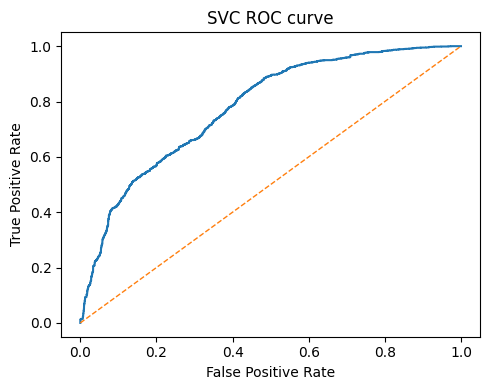

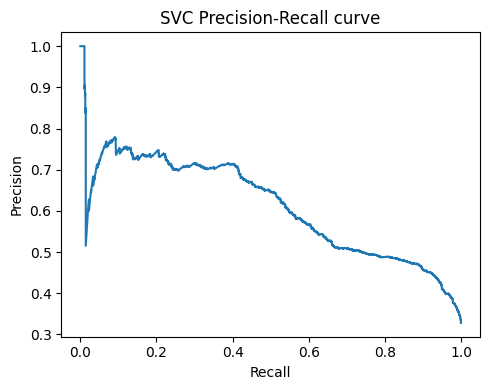

In [ ]:
fpr, tpr, _ = roc_curve(y_te_svc, scores)
prec, rec, _ = precision_recall_curve(y_te_svc, scores)
print(f"ROC-AUC={auc(fpr,tpr):.3f}  PR-AUC={auc(rec,prec):.3f}")

plt.figure(figsize=(5,4))
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1],'--', linewidth=1)
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("SVC ROC curve"); plt.tight_layout(); plt.show()

plt.figure(figsize=(5,4))
plt.plot(rec, prec)
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("SVC Precision-Recall curve"); plt.tight_layout(); plt.show()


**<ROC 곡선>**

대각선(무작위) 위로 꽤 올라가 있지만 완만한 곡선 → 중간 수준의 판별력.

FPR을 0.2로 허용해도 TPR(재현율)이 ~0.6대 정도로 보임

**<PR 곡선>**

좌측 상단에서 정밀도 ~0.75 수준으로 시작하지만 Recall이 커질수록 Precision이 급격히 하락.

Recall 0.8 근처에선 Precision이 ~0.5 전후로 떨어짐

**<요약>**

ROC-AUC = 0.778, PR-AUC = 0.611 → SVC가 랜덤(ROC 0.5)보다는 확실히 좋지만, 같은 데이터의 CatBoost(≈0.95/0.92)보단 꽤 약함

양성 비율(취소율) ≈ 0.33이므로 PR-AUC 0.611은 베이스라인(0.33) 대비 의미 있는 향상

In [ ]:
import numpy as np
import pandas as pd

# OHE 대상 자동 감지(없을 때 대비)
try:
    cat_cols_for_ohe
except NameError:
    cat_cols_for_ohe = X_tr_enc.select_dtypes(include=["object","category"]).columns.tolist()

# 원-핫 피처를 "원 변수" 단위로 묶기 위한 베이스 이름 추출 함수
def base_name(col: str) -> str:
    # scikit-learn 1.2+의 get_feature_names_out: "col_value" 형태
    # 일부 버전/설정은 "col=value"도 가능하므로 둘 다 처리
    # 없으면 그대로 반환(수치 변수 등)
    for c in cat_cols_for_ohe:
        if col.startswith(c + "_") or col.startswith(c + "="):
            return c
    return col


In [ ]:
from sklearn.inspection import permutation_importance

# 점수 기준: 불균형 대응을 위해 average_precision(=PR-AUC)을 사용
r = permutation_importance(
    estimator=svc,
    X=X_te_enc,
    y=y_te_svc,
    n_repeats=5,
    scoring="average_precision",
    random_state=42,
    n_jobs=-1
)

# 개별(원-핫 포함) 중요도 표
pi = (pd.DataFrame({
        "feature": X_te_enc.columns,
        "imp_mean": r.importances_mean,
        "imp_std":  r.importances_std
     })
     .sort_values("imp_mean", ascending=False)
     .reset_index(drop=True))

print("=== Permutation importance (Top 20, 원-핫 피처 포함) ===")
display(pi.head(20))

# 원 변수 단위로 그룹핑(원-핫 합계)
pi_group = (pi.assign(base=pi["feature"].map(base_name))
              .groupby("base", as_index=False)["imp_mean"].sum()
              .sort_values("imp_mean", ascending=False)
              .reset_index(drop=True))

print("\n=== Grouped importance by ORIGINAL feature (Top 20) ===")
display(pi_group.head(20))


=== Permutation importance (Top 20, 원-핫 피처 포함) ===


,feature,imp_mean,imp_std
0,lead_x_month,0.259453,0.007541
1,price_per_guest,0.020510,0.004729
2,arrival_month,0.016882,0.002815
3,no_of_special_requests,0.008819,0.000761
4,env_cancel_rate,0.006223,0.000276
5,peak_price,0.005929,0.001383
6,avg_price_per_room,0.002555,0.000192
7,total_guests,0.001394,0.000196
8,month_cos,0.001046,0.000159
9,no_of_adults,0.001035,0.000119



=== Grouped importance by ORIGINAL feature (Top 20) ===


,base,imp_mean
0,lead_x_month,0.259453
1,price_per_guest,0.020510
2,arrival_month,0.016882
3,no_of_special_requests,0.008819
4,env_cancel_rate,0.006223
5,peak_price,0.005929
6,avg_price_per_room,0.002555
7,total_guests,0.001394
8,month_cos,0.001046
9,no_of_adults,0.001035


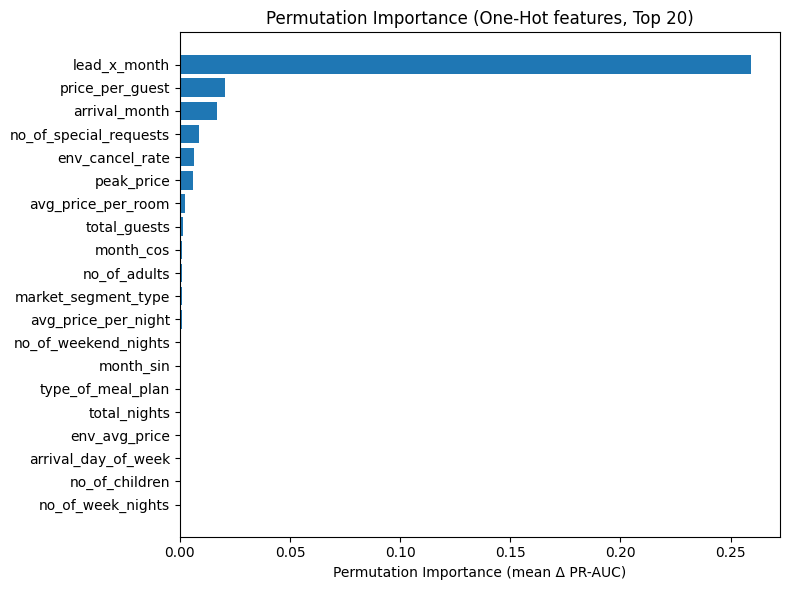

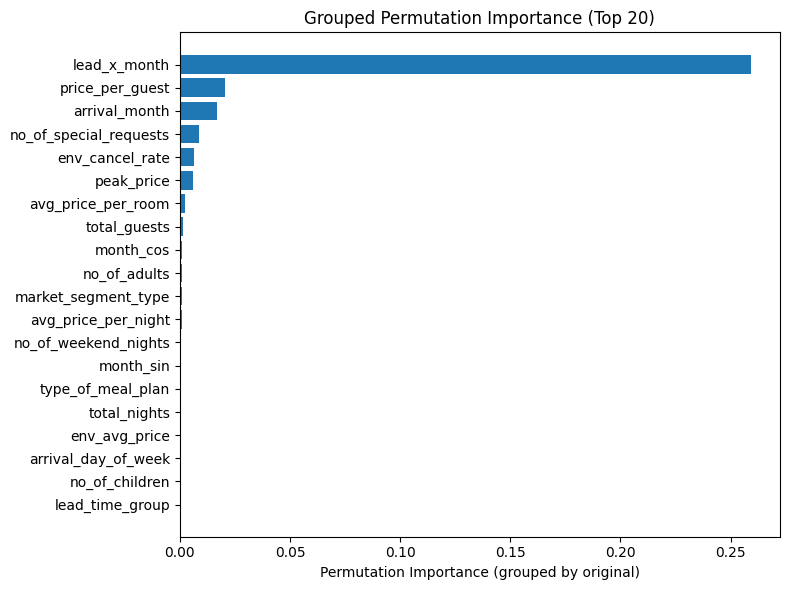

In [ ]:
import matplotlib.pyplot as plt

# Top-K 설정
K = 20

# 1) 개별(원-핫 포함)
pi_top = pi.head(K).iloc[::-1]
plt.figure(figsize=(8, 6))
plt.barh(pi_top["feature"], pi_top["imp_mean"])
plt.xlabel("Permutation Importance (mean Δ PR-AUC)")
plt.title("Permutation Importance (One-Hot features, Top 20)")
plt.tight_layout()
plt.show()

# 2) 원 변수 그룹
pg_top = pi_group.head(K).iloc[::-1]
plt.figure(figsize=(8, 6))
plt.barh(pg_top["base"], pg_top["imp_mean"])
plt.xlabel("Permutation Importance (grouped by original)")
plt.title("Grouped Permutation Importance (Top 20)")
plt.tight_layout()
plt.show()


### CatBoost

1. 스케일링, 이상치 제거 필요 없음
2. 카테고리 변수 자동 처리!
3. 파생변수 모두 사용

⭐️목표(초점을 둔 것): 취소 여부 예측

In [ ]:
df_cb = hotel.copy()

In [ ]:
cat_features = ["type_of_meal_plan", "room_type_reserved", "market_segment_type",
                "required_car_parking_space", "repeated_guest", "lead_time_group"]


X_cb = df_cb.drop(columns=["booking_status","arrival_date_full"])
y_cb = (df_cb["booking_status"] == "Canceled").astype(int)

In [ ]:
!pip install catboost

In [ ]:
hotel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36238 entries, 0 to 36237
Data columns (total 36 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   no_of_adults                          36238 non-null  int64         
 1   no_of_children                        36238 non-null  int64         
 2   no_of_weekend_nights                  36238 non-null  int64         
 3   no_of_week_nights                     36238 non-null  int64         
 4   type_of_meal_plan                     36238 non-null  int64         
 5   required_car_parking_space            36238 non-null  int64         
 6   room_type_reserved                    36238 non-null  int64         
 7   lead_time                             36238 non-null  int64         
 8   arrival_month                         36238 non-null  int64         
 9   market_segment_type                   36238 non-null  int64         
 10

###1. CatBoost 학습

In [ ]:
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool

# 타깃
y = (hotel["booking_status"] == "Canceled").astype(int)

# 입력 컬럼 (불필요 컬럼 제외)
drop_cols = ["booking_status", "arrival_date_full"]  # 필요시 "Booking_ID","arrival_year","arrival_date"도 제외
X = hotel.drop(columns=drop_cols).copy()

# 범주형 컬럼 표시
cat_cols = ["type_of_meal_plan","room_type_reserved","market_segment_type","lead_time_group"]
for c in cat_cols:
    if c in X.columns:
        X[c] = X[c].astype("category")

# train/test 분리 (규칙 고정: test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 클래스 가중치 계산
N  = len(y_train)
n1 = int(y_train.sum())
n0 = N - n1
class_weights = [N/(2*n0), N/(2*n1)]  # [weight_for_class0, weight_for_class1]

# CatBoost Pool 생성
cat_idx = [X_train.columns.get_loc(c) for c in cat_cols if c in X_train.columns]
train_pool = Pool(X_train, y_train, cat_features=cat_idx)
valid_pool = Pool(X_test,  y_test,  cat_features=cat_idx)

#학습
params = dict(
    iterations=500,
    depth=6,
    learning_rate=0.07,
    l2_leaf_reg=3.0,
    loss_function="Logloss",
    eval_metric="AUC",
    random_seed=42,
    early_stopping_rounds=100,
    verbose=False,
    class_weights=class_weights
)
model = CatBoostClassifier(**params)
model.fit(train_pool, eval_set=valid_pool, verbose=False)

print("best iter:", model.get_best_iteration())
print("best score:", model.get_best_score())


best iter: 499
best score: {'learn': {'Logloss': 0.24829717210138383}, 'validation': {'Logloss': 0.2881138805634168, 'AUC': 0.9494502444394686}}


- 'learn': {'Logloss': 0.248...}

→ 학습(train) 데이터에서의 로그손실(Logloss).

(0.248 → 꽤 낮음): 모델이 잘 맞췄다

- 'validation': {'Logloss': 0.288..., 'AUC': 0.949...}

→ 검증(validation) 데이터에서의 성능 지표

Logloss = 0.288 : 모델 예측 확률이 정답에 얼마나 잘 맞는지 보여줌 → 낮을수록 좋음.

AUC = 0.949 : 매우 높은 성능

###2. 테스트셋 성능 평가

In [ ]:
from sklearn.metrics import (roc_auc_score, average_precision_score, log_loss,
                             accuracy_score, precision_recall_fscore_support,
                             confusion_matrix)

proba = model.predict_proba(X_test)[:, 1]
pred05 = (proba >= 0.50).astype(int)

print("AUC       :", roc_auc_score(y_test, proba))
print("PR-AUC    :", average_precision_score(y_test, proba))
print("LogLoss   :", log_loss(y_test, proba))
print("Accuracy  :", accuracy_score(y_test, pred05))
p,r,f,_ = precision_recall_fscore_support(y_test, pred05, average="binary")
print("Precision :", p, "  Recall:", r, "  F1:", f)
print("Confusion Matrix\n", confusion_matrix(y_test, pred05))


AUC       : 0.9494502444394687
PR-AUC    : 0.9161922572019766
LogLoss   : 0.2872328302057037
Accuracy  : 0.8733443708609272
Precision : 0.7788829380260138   Recall: 0.8569023569023569   F1: 0.8160320641282565
Confusion Matrix
 [[4294  578]
 [ 340 2036]]


**<결과 해석(임계값 0.50 기준)>**



AUC = 0.949 / PR-AUC = 0.916

→ 확률 점수의 순위화 품질이 매우 높음(랜덤 0.5 대비 훨씬 우수). 불균형 상황에서도 양성(취소) 구분을 잘함.

LogLoss = 0.287

→ 예측 확률이 실제 라벨과 잘 맞음(확률 보정 수준도 양호한 편).

Accuracy = 0.873

→ 전체의 87.3%를 맞춤(하지만 비용이 다른 문제에선 Accuracy만으론 판단 불가).

Precision = 0.779 / Recall = 0.857 / F1 = 0.816

→ 취소라고 알린 예약 중 77.9%가 실제 취소, 실제 취소 중 85.7%를 잡아냄.

Confusion Matrix (y=0: Not_Canceled, y=1: Canceled)

[[TN  FP],

 [FN  TP]]

[[4294  578],

 [ 340 2036]]


TN=4294: 정상 예약을 정상으로 판단

FP=578: 정상인데 취소라고 경고(과잉 경보)

FN=340: 실제 취소를 놓침

TP=2036: 취소를 정확히 잡음

**[해석]**

“취소를 놓치지 않겠다”가 중요하면 Recall 0.857은 꽤 좋음. 다만 FP=578건의 과잉 경보가 있어 운영비용(불필요한 연락/보증요청 등)을 고려해 임계값을 조정할 수 있음.

랭킹 품질(AUC, PR-AUC)이 매우 높으므로, 상위 k% 고객에 집중하는 운영(예: 상위 10%에 사전확인/알림 강화)으로도 효과적.

###3. 임계값(Threshold) 튜닝 (F1 기준)

In [ ]:
import numpy as np
from sklearn.metrics import precision_recall_fscore_support

ths = np.linspace(0.1, 0.9, 81)
stats = []
for t in ths:
    pred = (proba >= t).astype(int)
    p,r,f,_ = precision_recall_fscore_support(y_test, pred, average="binary")
    stats.append((t,p,r,f))
best_t, best_p, best_r, best_f = sorted(stats, key=lambda x: x[3], reverse=True)[0]
print(f"Best threshold by F1: {best_t:.3f}  (P={best_p:.3f}, R={best_r:.3f}, F1={best_f:.3f})")

# 최적 임계값에서 혼동행렬
best_pred = (proba >= best_t).astype(int)
print("Confusion @ best_t\n", confusion_matrix(y_test, best_pred))


Best threshold by F1: 0.640  (P=0.846, R=0.806, F1=0.825)
Confusion @ best_t
 [[4524  348]
 [ 462 1914]]


**<의미>**

임계값을 0.50 → 0.64로 올리면

오탐(FP): 578 → 348 (↓230) → 쓸데없는 경보가 많이 줄었음.

미탐(FN): 340 → 462 (↑122) → 실제 취소를 더 많이 놓침.

정밀도↑(0.78 ⇒ 0.85), 재현율↓(0.86 ⇒ 0.81), F1 소폭↑(0.816 ⇒ 0.825).

특이도 0.881 ⇒ 0.928, FPR 0.119 ⇒ 0.071로 개선.



**“과잉 경보를 줄이고 싶다”** 면 t=0.64가 더 적합(Precision↑, FP↓).

**“실제 취소를 절대 놓치면 안 된다”** 면 t=0.50처럼 더 낮은 임계값이 낫다(Recall↑, FN↓).

F1은 정밀도와 재현율을 동일 가중으로 본 지표라, 두 비용이 비슷하다고 볼 때 t=0.64 채택이 합리적.

###4. 변수 중요도 & SHAP (해석)

- FeatureImportance: 트리를 분할할 때 손실을 얼마나 줄였는지의 누적 기여도(모델 내부 기준).

- SHAP mean_abs_shap: 각 피처가 예측(로짓)에 미친 평균 절대 영향량. 값이 클수록 “영향이 큰 피처”.

| 항목        | Feature Importance(CatBoost)    | Global SHAP Importance                     |
| --------- | ------------------------------- | ------------------------------------------ |
| 기준        | **학습 중 분할 이득(손실 감소)** 누적        | **예측 결과의 기여도(샘플별 SHAP)의 평균 크기**            |
| 관점        | **모델이 트리를 어떻게 만들었는가**(학습 과정 중심) | **완성된 모델 예측을 누가 움직였는가**(예측 결과 중심)          |
| 국소 vs. 전역 | 일부 구간에서 큰 이득이면 높아질 수 있음         | **전 샘플 평균**이므로 **넓게 고르게** 영향 주면 높아짐        |
| 방향(↑/↓)   | 제공 안 함                          | 전역 막대는 방향 X, **개별 SHAP**으로 방향/비선형 확인       |
| 상관/중복 변수  | 한 변수에 중요도가 **쏠리거나 분산**될 수 있음    | 상관 변수끼리는 **기여를 나눠 가짐**(완벽하진 않음)            |
| 일관성       | 파라미터/시드 변화에 다소 민감할 수 있음         | 대체로 **설명 일관성**이 좋음(트리 모델은 TreeSHAP로 정확 계산) |



Feature Importance ↑ & SHAP ↑: 모델도 자주/크게 썼고, 예측에도 넓게 큰 영향 → 핵심 피처.

Feature Importance ↑ & SHAP ↓: 일부 구간에서만 큰 이득(스플릿)

Feature Importance ↓ & SHAP ↑: 분할 이득은 작게 여러 번이지만 전반에 걸쳐 고르게 영향 → 규칙적으로 넓게 작동하는 피처.

In [ ]:
import pandas as pd

# 1) 표준 중요도
imp = model.get_feature_importance(train_pool, type="FeatureImportance")
fi = (pd.DataFrame({"feature": X_train.columns, "importance": imp})
        .sort_values("importance", ascending=False))
print(fi.head(20))

# 2) SHAP 전역 중요도
shap_vals = model.get_feature_importance(data=train_pool, type="ShapValues")
shap_abs_mean = np.abs(shap_vals[:, :-1]).mean(axis=0)
shap_df = (pd.DataFrame({"feature": X_train.columns, "mean_abs_shap": shap_abs_mean})
             .sort_values("mean_abs_shap", ascending=False))
print(shap_df.head(20))



                       feature  importance
14      no_of_special_requests   17.848313
13          avg_price_per_room   12.154827
7                    lead_time   11.644195
9          market_segment_type   10.909389
31               log_lead_time    7.147316
32                lead_x_month    5.197806
8                arrival_month    4.981733
26                   month_cos    4.200087
16             lead_time_group    3.773147
29             price_per_guest    3.234266
17         avg_price_per_night    3.068046
3            no_of_week_nights    2.295416
30                  peak_price    2.004316
2         no_of_weekend_nights    1.943269
5   required_car_parking_space    1.857147
25                   month_sin    1.683130
0                 no_of_adults    0.773884
27                     dow_sin    0.695861
15                total_nights    0.540137
4            type_of_meal_plan    0.526304
                       feature  mean_abs_shap
14      no_of_special_requests       1.262906
9    

**핵심 변수 요약(공통 상위권)**

(Feature Importance가 높다는 건 그 변수가 취소/비취소를 가르는 데 강한 구분력을 제공한다는 뜻)

1. no_of_special_requests

- 최상위. “요청을 많이 남긴 예약”이 모델 예측에 큰 영향. (일반적으로는 취소 ↓ 쪽으로 작용하는 경우가 많음—의도/몰입도가 높으니)

2. lead_time / log_lead_time (+ lead_time_group)

- 리드타임 관련 변수가 모두 상위권 → 비선형성/구간 효과까지 유의미. 보통 리드타임이 길수록 취소 위험 ↑ 경향.

3. market_segment_type

- 세그먼트(Online/Offline 등)별 취소 패턴 차이가 큼.

4. avg_price_per_room / price_per_guest / avg_price_per_night

- 가격 수준이 취소에 의미 있게 관여.

5. seasonality 변수: arrival_month, month_cos/sin, lead_x_month

- 월·시즌 효과가 존재(성수기/비성수기).

6. required_car_parking_space

- 중상위권. 주차 필요 여부도 신호.

- (상대적으로 하위) no_of_adults, total_guests, room_type_reserved 등은 영향이 작음.


###5. 시각화

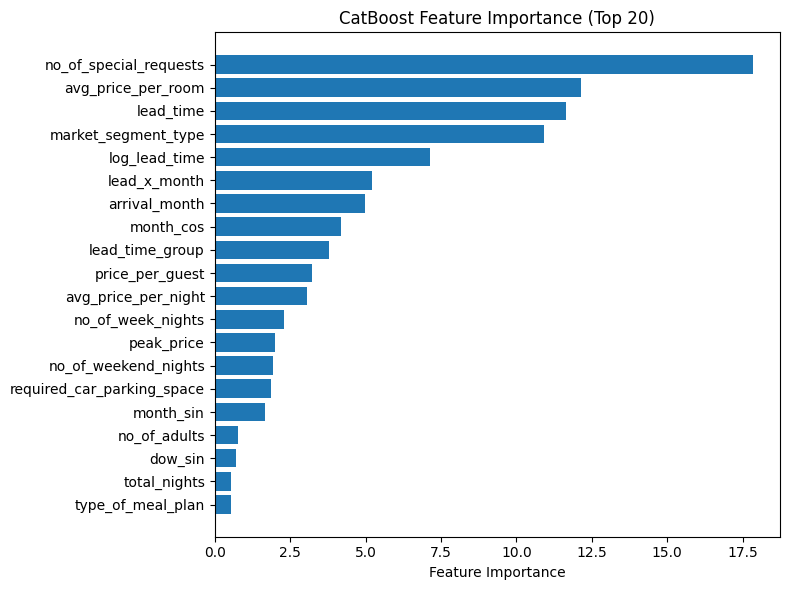

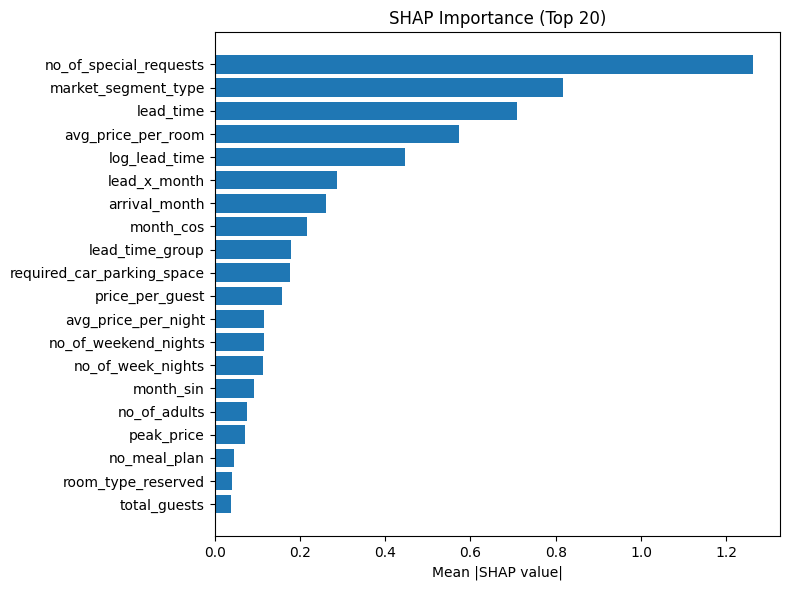

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 0) 필요 객체 확인 후 준비
# FeatureImportance DataFrame(fi) 없으면 새로 계산
try:
    fi
except NameError:
    imp = model.get_feature_importance(train_pool, type="FeatureImportance")
    fi  = (pd.DataFrame({"feature": X_train.columns, "importance": imp})
             .sort_values("importance", ascending=False))

# SHAP 요약 DataFrame(shap_df) 없으면 빠르게 샘플링해서 계산
try:
    shap_df
except NameError:
    # 과부하 방지: 학습 데이터 일부만 사용 (최대 3000행)
    n = min(len(X_train), 3000)
    idx = np.random.RandomState(42).choice(len(X_train), size=n, replace=False)
    sub_pool = train_pool.slice(idx)
    shap_vals = model.get_feature_importance(data=sub_pool, type="ShapValues")
    shap_abs_mean = np.abs(shap_vals[:, :-1]).mean(axis=0)
    shap_df = (pd.DataFrame({"feature": X_train.columns, "mean_abs_shap": shap_abs_mean})
                 .sort_values("mean_abs_shap", ascending=False))

# 1) Feature Importance (Top 20)
topk = 20
fi_top = fi.head(topk).iloc[::-1]  # barh 가독성 위해 역순

plt.figure(figsize=(8, 6))
plt.barh(fi_top["feature"], fi_top["importance"])
plt.xlabel("Feature Importance")
plt.title("CatBoost Feature Importance (Top 20)")
plt.tight_layout()
plt.show()

# 2) SHAP Mean |value| (Top 20)
shap_top = shap_df.head(topk).iloc[::-1]

plt.figure(figsize=(8, 6))
plt.barh(shap_top["feature"], shap_top["mean_abs_shap"])
plt.xlabel("Mean |SHAP value|")
plt.title("SHAP Importance (Top 20)")
plt.tight_layout()
plt.show()
